# Topology optimization tutorial: Raman acive medium
We recommend looking through the molecule case first as this document will draw comparisons to that one.

In [2]:
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp
from jax import jit
import numpy as np
import os
import design_tools as dt
import maxwell_operator as operator
import jax.experimental.sparse as jsp
import TM_FDFD_jax as TM

jax.config.update('jax_platform_name', 'cpu')
os.environ['JAX_PLATFORMS'] = 'cpu' # This code is a bit faster on GPU for sufficiently large systems, but this is not extensively tested for now. The designs presented in this paper were calculated on CPU.
print(jax.devices()) # This should print a list of CPU devices. If this errors because you have a JAX GPU build, just run this again. 

[CpuDevice(id=0)]


In [3]:
# Define relevant parameters for the optimization
gpr = 80 # gridpoints per length unit 
wv1 = 1.0 # Wavelength of the pump source
wv2 = 1.0 # Wavelength of the Raman source
alpha = 0.01 # Raman polarizability (1 for molecule, 0.01 for active)
r = 0.3 # Outer radius (corresponds to L = 0.6 in paper)
ri = 0.0 # Inner radius (for active medium, set to 0)
circle = False # The Raman medium case was studied for square structures 
chi = 10+0.1j # Linear susceptibility
chibkg = 0 # Background susceptibility = vacuum
pml_thick = 0.3 # Thickness of the PML
pml_sep = 0.3 # Separation between the PML and the design region

dl = 1/gpr 
Mx = int(np.round(2*r/dl))+1 # Total number of pixels in design region in x direction, +1 to center the dipole 
My = int(np.round(2*r/dl))+1 # Total number of pixels in design region in y direction
Mi = int(np.round(ri/dl)) # Inner radius of design region
Npml = int(np.round(pml_thick/dl)) 
Npmlsep = int(np.round(pml_sep/dl))
nonpmlNx = Mx + 2*Npmlsep 
nonpmlNy = My + 2*Npmlsep 
Nx = nonpmlNx + 2*Npml
Ny = nonpmlNy + 2*Npml

e0, Z, C = 1, 1, 1
k1, k2 = 2*np.pi/wv1, 2*np.pi/wv2
omega1, omega2 = 2*np.pi*C/wv1, 2*np.pi*C/wv2

Number of pixels in design region: 2401
Design mask shape: (145, 145)


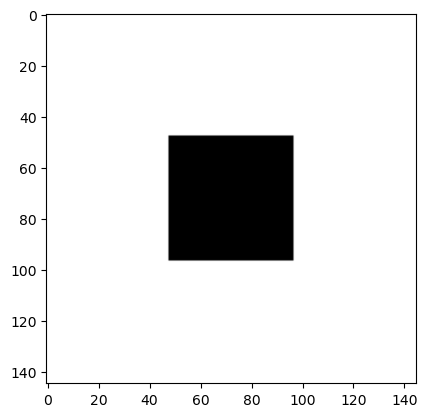

In [4]:
# Initialize a structure and visualize it (same as molecule case)
design_mask, ndof = dt.init_domain(Nx, Ny, Mx, My, Mi, Npml, Npmlsep, nonpmlNx, nonpmlNy, circle)
plt.imshow(design_mask, cmap='binary')
print('Number of pixels in design region:', ndof)
print('Design mask shape:', design_mask.shape)

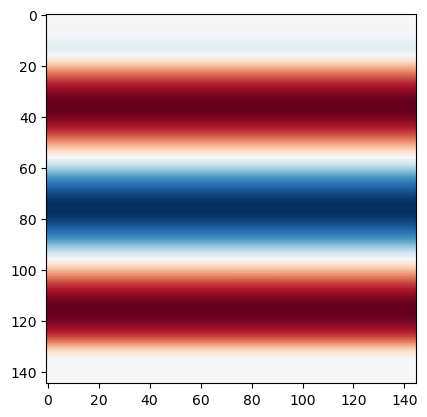

In [5]:
# Same as the molecule, but we also calculate the incident power 
# Initialize the Maxwell operators and calculate the incident field 
M1_np = operator.get_TM_MaxwellOp(wv1, 1/gpr, Nx, Ny, (Npml, Npml), bloch_x=0.0, bloch_y=0.0, Qabs=np.inf)
M2_np = operator.get_TM_MaxwellOp(wv2, 1/gpr, Nx, Ny, (Npml, Npml), bloch_x=0.0, bloch_y=0.0, Qabs=np.inf)
M1 = jsp.BCOO.from_scipy_sparse(M1_np)
M2 = jsp.BCOO.from_scipy_sparse(M2_np)

Ez_line = TM.get_TM_linesource_field(M1, wv1, dl, Nx, Ny, Npml+Npmlsep//2, amp=1, chigrid=None)
plt.imshow(np.real(Ez_line), cmap='RdBu') # Plot incident field
incpow = np.abs(Ez_line[Nx//2, Nx//2])**2/Z

In [6]:
def embed_sourcegrid(source):
    sourcegrid = jnp.zeros((Nx, Ny), dtype=complex)
    sourcegrid = sourcegrid.at[design_mask].add(source)
    return sourcegrid

# Define the objective function
def raman_scattered(rho, linex):
    # Main differences with molecule case:
    # 1. The normalization is the incident power (there is no dipole)
    # 2. The Raman field is sourced where the material is, scaled by the density of the material 
    # 3. The LDOS is an integral J* dot E, J* is no longer a delta function. 

    rho_clipped = jnp.clip(rho, 0, 1) # Ensure that the density is between 0 and 1
    chigrid = dt.getchi(rho_clipped, chi, chibkg, Nx, Ny, design_mask) # get the distribution of chi

    Ez_line = TM.get_TM_linesource_field(M1, wv1, dl, Nx, Ny, linex, amp=1, chigrid=chigrid) # simulate the incident field
    sourcegrid = embed_sourcegrid(-1j*omega2*alpha*Ez_line[design_mask]*rho_clipped)

    Ez = TM.get_TM_field(M2, wv2, Nx, Ny, sourcegrid, chigrid=chigrid) # Simulate the Raman field 

    ldos = -0.5 * jnp.real(jnp.sum((sourcegrid.conjugate() * Ez * design_mask))*dl*dl)/incpow # calculate the LDOS
    absorbed = jnp.real((omega2/2)*jnp.real(jnp.sum(jnp.conjugate(Ez)*Ez * jnp.imag(chigrid) * design_mask) * dl*dl) / incpow) # calculate the absorbed power 
    
    # jax.debug.print("ldos = {x}, abs = {y}, scat = {z}", x = ldos, y=absorbed, z=ldos-absorbed)

    scattered_power = ldos - absorbed
    return -scattered_power # - sign because we want to maximize the scattered power

# Define the problem-specific objective function 
loss = jit(lambda rho: raman_scattered(rho, Npml+Npmlsep//2))


-1.8575989e-05


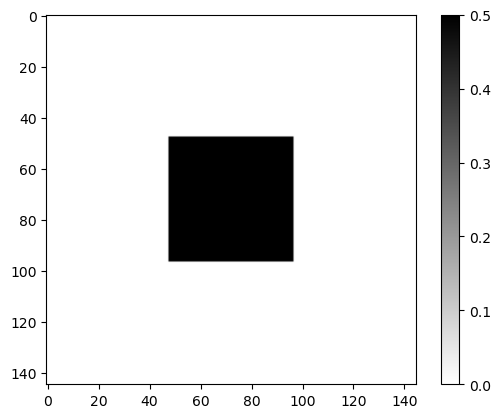

In [ ]:
# This is the same as the molecule case. 

# Function to embed the design into a larger grid for plotting 
def embed_rho(rho):
    big_rho = np.zeros((Nx, Ny))
    big_rho[design_mask] = rho
    return big_rho 

init_rho = jnp.ones(ndof)/2 # Initialize the design to be a uniform distribution of material. 
# init_rho = jnp.array(np.random.random(ndof)) # Initialize random (try both)
plt.imshow(embed_rho(init_rho), cmap='binary')
plt.colorbar()

print(loss(init_rho)) # Check that the loss function is working

In [8]:
# Exact same as molecule case.
# Newer iterations of this code use optax (which is meant to replace jaxopt), but this paper utilizes jaxopt. 

# Older jaxopt method (still works, replicate paper)
# import jaxopt 
# maxiter = 100
# lb = jnp.zeros_like(init_rho) # lower and upper bounds on rho for projected gradient descent 
# up = jnp.ones_like(init_rho)
# pg = jaxopt.ProjectedGradient(fun=loss, projection=jaxopt.projection.projection_box, maxiter=maxiter, jit=True)
# # Run the optimization
# pg_sol = pg.run(init_rho, hyperparams_proj=(lb, up))
# rho_opt = pg_sol.params

# Newer optax method 
gloss = jax.grad(loss)
import optax
step = 0
eps_conv = 1e-5
miniter = 20
maxiter = 150
lr = 0.01 # learning rate 
rho_opt = init_rho

current_loss = loss(rho_opt)
old_loss = np.inf
print(f'initial loss: {current_loss}') # (will print negative, we are minimizing -objective)
print(f'number of optimization parameters: {len(rho_opt)}')

solver = optax.adam(learning_rate = lr)
opt_state = solver.init((rho_opt))

while ((np.abs((old_loss - current_loss)/current_loss) > eps_conv) or (step < miniter)) and (step < maxiter):
    old_loss = current_loss
    gradient = gloss(rho_opt)
    updates, opt_state = solver.update(gradient, opt_state, (rho_opt))
    rho_opt = optax.apply_updates((rho_opt), updates)
    
    current_loss = loss(rho_opt)

    if step % 1 == 0:
        print(f'step {step}, loss: {-current_loss}')

    step += 1



initial loss: -1.85759890882764e-05
number of optimization parameters: 2401
step 0, loss: 2.1826333977514878e-05
step 1, loss: 2.550867611716967e-05
step 2, loss: 2.9552178602898493e-05
step 3, loss: 3.384327646926977e-05
step 4, loss: 3.8258007407421246e-05
step 5, loss: 4.269479541108012e-05
step 6, loss: 4.711961810244247e-05
step 7, loss: 5.1604481996037066e-05
step 8, loss: 5.63203138881363e-05
step 9, loss: 6.147458771010861e-05
step 10, loss: 6.722970283590257e-05
step 11, loss: 7.361859024967998e-05
step 12, loss: 8.04574228823185e-05
step 13, loss: 8.72720847837627e-05
step 14, loss: 9.334814239991829e-05
step 15, loss: 9.813898213906214e-05
step 16, loss: 0.00010205074795521796
step 17, loss: 0.00010632165503920987
step 18, loss: 0.0001116842613555491
step 19, loss: 0.00011785537208197638
step 20, loss: 0.00012410321505740285
step 21, loss: 0.00013021717313677073
step 22, loss: 0.0001369773963233456
step 23, loss: 0.00014539342373609543
step 24, loss: 0.00015583165804855525
s

0.0014052357


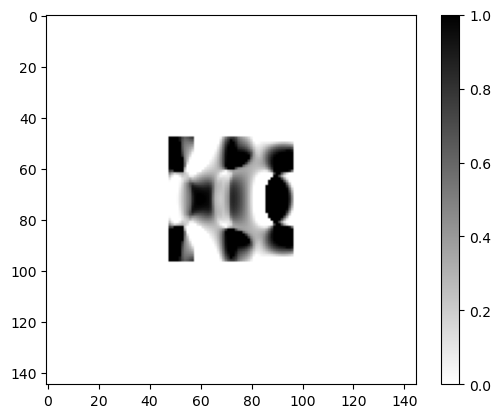

In [ ]:
# Visualize final structure and compute its performance.
rho_clip = jnp.clip(rho_opt, 0, 1) # Gradient to increase rho beyond 1 should be zero, but it may still happen due to overstepping a gradient step (the objective clips it, so it doesn't improve the objective to take rho > 1 or rho rho < 0). We clip it at the end for plotting purposes. 
plt.imshow(embed_rho(rho_clip).T, cmap='binary') # Transpose to fit convention in paper (source from left not top)
plt.colorbar()

# Calculate the performance of the design
print(-loss(rho_clip))

# Performance of L = 0.6, dielectric should be slightly over 1e-3 (see Fig 3). Here we get a performance of ~1e-3 without too much effort
# One technique to fine-tune designs used in the paper is to run lower resolution designs (as done here) then iteratively feeding lower resolution designs into higher-resolution runs to refine the design. Thsi can eek out more performance in these inverse designs. 